<a href="https://colab.research.google.com/github/tawaqalt/arbritrary/blob/master/Tawakalitu_Yusuf_Deep_Neural_Network_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation of Libraries

In [1]:
#importing relevant libraries
import numpy as np
import pandas as pd
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


# [Problem 1] Classifying fully connected layers

In [21]:
# SGD Class
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, W, B, dW, dB):
        W -= self.lr * dW / len(dW)
        B -= self.lr * dB / len(dB)
        return W, B

In [3]:
class FullyConnectedLayer:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0

    def forward(self, X):
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A

    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        dX = dA @ self.W.T
        self.W, self.B = self.optimizer.update(self.W, self.B, self.dW, self.dB)
        return dX

# [Problem 2] Classifying the initialization method

In [4]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        W = np.random.randn(n_nodes1, n_nodes2) * self.sigma
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

# [Problem 3] Classifying optimization methods

In [5]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, W, B, dW, dB):
        W -= self.lr * dW / len(dW)
        B -= self.lr * dB / len(dB)
        return W, B

# [Problem 4] Classifying activation functions

In [6]:
class Sigmoid:
    def forward(self, A):
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z

    def backward(self, dout):
        dA = dout * (1 - dout)
        return dA

class Tanh:
    def forward(self, A):
        self.A = A
        Z = np.tanh(self.A)
        return Z

    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A) ** 2)
        return dA

class Softmax:
    def forward(self, A):
        self.A = A
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        Z = exp_A / np.sum(exp_A, axis=1, keepdims=True)
        return Z

    def backward(self, Z, y):
        m = len(y)
        dA = Z - y
        loss = -np.sum(y * np.log(Z + 1e-10)) / m
        return dA, loss

# [Problem 5] ReLU class creation

In [7]:
class ReLU:
    def forward(self, A):
        self.A = A
        Z = np.maximum(0, self.A)
        return Z

    def backward(self, dZ):
        dA = dZ * (self.A > 0)
        return dA

# [Problem 6] Initial value of weight

In [8]:
class XavierInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        W = np.random.randn(n_nodes1, n_nodes2) * self.sigma * np.sqrt(1 / n_nodes1)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

class HeInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        W = np.random.randn(n_nodes1, n_nodes2) * self.sigma * np.sqrt(2 / n_nodes1)
        return W

    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

# [Problem 7] Optimization method

In [9]:
class Adagrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = 0
        self.HB = 0

    def update(self, W, B, dW, dB):
        self.HW += dW ** 2
        self.HB += dB ** 2
        delta = 1e-7
        W -= self.lr * dW / (np.sqrt(self.HW) + delta) / len(dW)
        B -= self.lr * dB / (np.sqrt(self.HB) + delta) / len(dB)
        return W, B

# [Problem 8] Class completion

In [10]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(X.shape[0])
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [22]:
# Deep Neural Network Classifier
class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, verbose=False, epoch=1, optimizer=SGD, initialize=SimpleInitializer, activation=ReLU):
        self.verbose = verbose
        self.epoch = epoch
        self.optimizer = optimizer
        self.initialize = initialize
        self.activation = activation
        self.batch_size = 20
        self.features = 784
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.output = 10
        self.sigma = 0.02
        self.lr = 0.5

    def fit(self, X, y, X_val, y_val):
        self.loss_train = []
        self.loss_val = []
        optimizer = self.optimizer(self.lr)
        self.FullyConnectedLayer1 = FullyConnectedLayer(self.features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = self.activation()
        self.FullyConnectedLayer2 = FullyConnectedLayer(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = self.activation()
        self.FullyConnectedLayer3 = FullyConnectedLayer(self.n_nodes2, self.output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            loss_batch_train = []
            for mini_X, mini_y in get_mini_batch:
                A1 = self.FullyConnectedLayer1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FullyConnectedLayer2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FullyConnectedLayer3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                dA3, loss = self.activation3.backward(Z3, mini_y)
                loss_batch_train.append(loss)
                dZ2 = self.FullyConnectedLayer3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FullyConnectedLayer2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                self.FullyConnectedLayer1.backward(dA1)

            self.loss_train.append(np.mean(loss_batch_train))

            # Validation
            A1 = self.FullyConnectedLayer1.forward(X_val)
            Z1 = self.activation1.forward(A1)
            A2 = self.FullyConnectedLayer2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FullyConnectedLayer3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            _, loss_val = self.activation3.backward(Z3, y_val)
            self.loss_val.append(loss_val)

            if self.verbose:
                print(f'Epoch {i+1}/{self.epoch} - loss: {self.loss_train[-1]:.4f} - val_loss: {self.loss_val[-1]:.4f}')

    def predict(self, X):
        A1 = self.FullyConnectedLayer1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FullyConnectedLayer2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FullyConnectedLayer3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)

# Plot Learning Curve
    def plot_learning_curve(loss_train, loss_val):
      epochs = range(1, len(loss_train) + 1)
      plt.plot(epochs, loss_train, 'b', label='Training loss')
      plt.plot(epochs, loss_val, 'r', label='Validation loss')
      plt.title('Training and validation loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

In [23]:
#reshaping
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
#Converting the data type to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#Normalizing the data
X_train /= 255
X_test /= 255

In [24]:
#splitting of data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [25]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = encoder.transform(y_val[:, np.newaxis])

In [32]:
#Instantaiting the scratch code
SDDNN = ScratchDeepNeuralNetworkClassifier(verbose=False, epoch=10, optimizer=SGD, initialize=HeInitializer, activation=ReLU)
#fitting the data
SDDNN.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)
#predicting on new data
y_pred = SDDNN.predict(X_val)

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

0.11447916666666667

In [34]:
# Plot Learning Curve
def plot_learning_curve(loss_train, loss_val):
    epochs = range(1, len(loss_train) + 1)
    plt.plot(epochs, loss_train, 'b', label='Training loss')
    plt.plot(epochs, loss_val, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

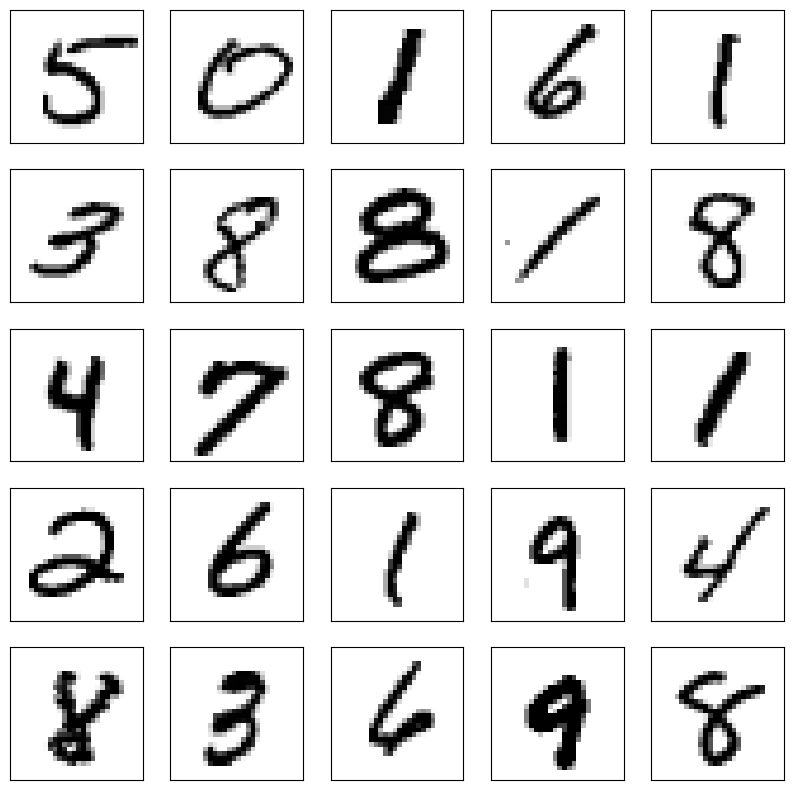

In [17]:
# Display MNIST Images
def display_mnist_images(X):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.show()

# Display some MNIST images
display_mnist_images(X_train)

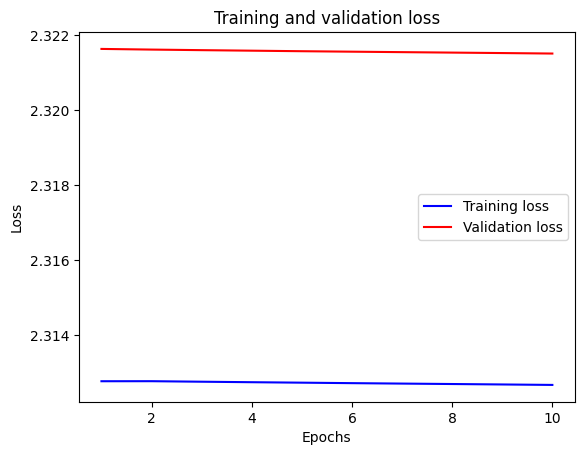

In [28]:
# Plot the learning curve
plot_learning_curve(SDDNN.loss_train, SDDNN.loss_val)

# Predict on test data
y_pred = SDDNN.predict(X_test)